In [1]:
import numpy as np 

from scipy.integrate import solve_ivp

from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt 

#mpl.style.use('seaborn')

from functools import partial 
from tqdm import tqdm 
 
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

tqdm = partial(tqdm, position=0, leave=True)


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def f_translation(x, y): 
    return 0. 

def single_solve(y0): 
    return solve_ivp(f_translation, t_span=[-1, 1], y0=[y0], t_eval=np.linspace(-1., 1., 20))


In [3]:
x, y = np.linspace(-2., 2., 35), np.linspace(-2., 2., 35) 
X, Y = np.meshgrid(x, y) 

dYdX = f_translation(X, Y)
U = (1. / (1. + dYdX**2) ** 0.5) * np.ones(Y.shape) 
V = (1. / (1. + dYdX**2) ** 0.5) * dYdX


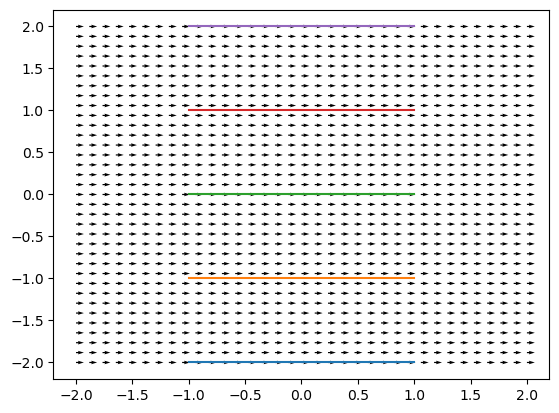

In [4]:
plt.quiver(X, Y, U, V, cmap='coolwarm')

y0s = np.linspace(-2., 2., 5)

for y0 in y0s: 
    res = single_solve(y0) 
    resx, resy = res.t, res.y.flatten() 

    plt.plot(resx, resy)



In [5]:
# accurate 1D shift operator Shannon-Whittaker Interpolation
shift = Q = lambda d,z: np.sum([1/d * np.cos(2*np.pi*p/d *z) for p in np.arange(-d/2+1,d/2)], axis=0)

# generator of 1D translations
L0 = lambda d,z: np.sum([-2*np.pi*p/d**2 * np.sin(2*np.pi*p/d *z) for p in np.arange(-d/2+1,d/2)], axis=0)

# cosine correlation 
coscorr = lambda x,y: np.trace(x.T@y)/np.norm(x)/np.norm(y)

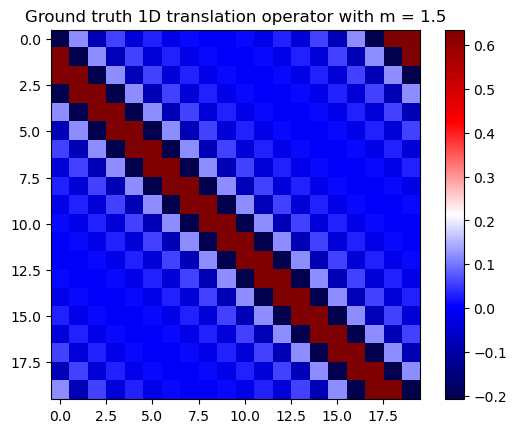

In [6]:
d = 20
m = 1.5
z = np.arange(d)[:,np.newaxis]-np.arange(d)
plt.imshow(Q(d,z-m), cmap = 'seismic') # vmin=-1, vmax=1
plt.title(f"Ground truth 1D translation operator with m = {m}")
plt.colorbar()

In [7]:
DIM = 20 

class FixedTranslation(datasets.VisionDataset):
    def __init__(self, *args, dx = 40, N = 50_000, dataseed=0, dataset, **kwargs):
        super().__init__(*args, **kwargs)

        self.affine_translation_matrix = torch.Tensor([
            1, 0, 0, 
            0, 1, dx / (2 * DIM)  
        ])[None]

        self.data = np.zeros([N, 1, DIM, DIM])

        for i in range(0, N): 
            resy = (np.rint(dataset[i]*9)).astype(int) // 2
            resy = -resy + 9
            for xi in range(0, DIM):
                #print(xi, resy.shape)
                self.data[i][0][resy[xi]][xi] = 1.

        self.data = torch.Tensor(self.data)
        print(N, self.data.shape)

        torch.manual_seed(dataseed) 

        with torch.no_grad(): 
            affineMatrices = torch.zeros(N, 2, 3)
            affineMatrices[:, 0, 0] = 1 
            affineMatrices[:, 1, 1] = 1
            affineMatrices[:, 1, 2] = dx / (2 * DIM)

            flowgrid = F.affine_grid(affineMatrices, size=self.data.shape)

            self.data_translated = F.grid_sample(self.data, flowgrid)

    def __getitem__(self, idx): 
        return self.data[idx], self.data_translated[idx]
    
    def __len__(self): 
        return len(self.data) 


In [8]:
NSolve = 10_000
rez = np.zeros([NSolve, 20])

y0s = np.linspace(-2., 2., NSolve)

for idx, y0 in enumerate(tqdm(y0s)): 
    res = single_solve(y0) 
    resx, resy = res.t, res.y.flatten() 

    rez[idx] = resy

100%|██████████| 10000/10000 [00:04<00:00, 2249.31it/s]


10000 torch.Size([10000, 1, 20, 20])


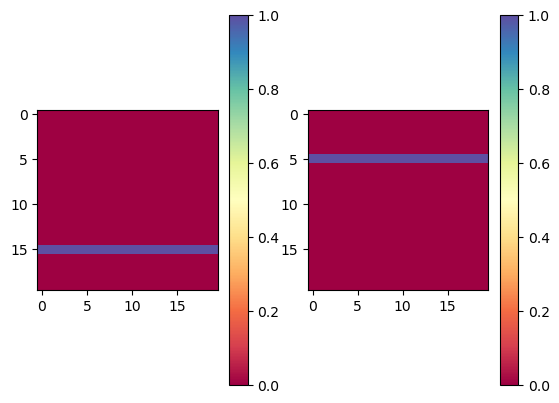

In [13]:
test_translation = FixedTranslation

dx = 40 # 20 
dataset1 = test_translation('../data', dx=dx, N=NSolve, dataset=rez)

data, data_translated = dataset1.__getitem__(2000)

plt.subplot(121)
plt.imshow(data.squeeze(), cmap='Spectral')
plt.colorbar()

plt.subplot(122) 
plt.imshow(data_translated.squeeze(),cmap='Spectral')
plt.colorbar()

